# Data Analysis Notebook
In this notebook, we analyze the **final processed personal health dataset** containing:
- Days, Weight(kg), Step_count, Gym, Calorie(kcal)
- Additional engineered columns: Gym_Bool, Day_Type, Weight_Change, Step_RollingAvg_7d

## Table of Contents
1. [Introduction](#introduction)
2. [Research Questions](#research-questions)
3. [Imports & Data Loading](#imports-and-data)
4. [Exploratory Data Analysis (EDA)](#eda)
   - [Univariate Analysis](#univariate)
   - [Bivariate Analysis](#bivariate)
   - [Multivariate Analysis & Outliers](#multivariate)
5. [Question 1: Calorie Intake & Weight Changes](#q1)
6. [Question 2: Physical Activity & Weight Management](#q2)
7. [Question 3: Interplay Between Calorie Intake & Physical Activity](#q3)
8. [Question 4: Temporal Patterns & Trends](#q4)
9. [Conclusion](#conclusion)


<a id='introduction'></a>
## 1. Introduction
The dataset captures daily records of **body weight**, **steps**, **calories**, and whether or not a gym session occurred. We have also derived features like:
- **Gym_Bool**: `True` if Gym == "Yes`, otherwise `False`.
- **Day_Type**: Whether the day is a `Weekday` or `Weekend`.
- **Weight_Change**: The day-to-day difference in weight.
- **Step_RollingAvg_7d**: A 7-day rolling average of step counts.

Our goal is to address multiple research questions through statistical tests and patterns in the data, focusing on how calorie intake and physical activity correlate with weight changes, as well as potential temporal trends.

<a id='research-questions'></a>
## 2. Research Questions
1. **Calorie Intake & Weight Changes**  
   - *How does daily calorie intake correlate with weight fluctuations?*  
   - *Are there patterns that precede weight gain or loss?*

2. **Physical Activity & Weight Management**  
   - *What is the relationship between daily steps/gym visits and weight changes?*  
   - *Does higher physical activity contribute significantly to weight loss or maintenance?*

3. **Interplay Between Calorie Intake & Physical Activity**  
   - *How do calories and steps together influence weight over time?*  
   - *Which combinations of calorie consumption and activity appear optimal?*

4. **Temporal Patterns & Trends**  
   - *Are there weekday/weekend differences in weight, steps, or calories?*  
   - *Are there long-term trends or seasonal patterns?*


<a id='imports-and-data'></a>
## 3. Imports & Data Loading
We'll bring in necessary Python libraries and load the `my_personal_health_data_processed.csv` file, which was produced after data processing.

Then we will check the first few rows of the dataset to confirm it loaded correctly.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_theme(style="whitegrid", context="notebook")

# Load the processed data
df = pd.read_csv("my_personal_health_data_processed.csv")

print("Data loaded. Shape:", df.shape)
display(df.head())

Data loaded. Shape: (43, 9)


,Days,Weight(kg),Step_count,Gym,Calorie(kcal),Gym_Bool,Day_Type,Weight_Change,Step_RollingAvg_7d
0,Thursday,89.5,4500,Yes,3410,True,Weekday,0.0,0.0
1,Sunday,89.3,3254,Yes,3410,True,Weekend,-0.2,0.0
2,Monday,91.2,4149,No,3410,False,Weekday,1.9,0.0
3,Tuesday,90.8,7342,Yes,3410,True,Weekday,-0.4,0.0
4,Wednesday,90.7,7784,Yes,3410,True,Weekday,-0.1,0.0


### Basic Observations:
- We expect ~43-44 rows.
- We see columns like `Days, Weight(kg), Step_count, Calorie(kcal), Gym_Bool, Day_Type, Weight_Change, Step_RollingAvg_7d`.
If everything looks correct, we can proceed with EDA.

<a id='eda'></a>
## 4. Exploratory Data Analysis (EDA)
We'll conduct **univariate**, **bivariate**, and **multivariate** analysis, along with an **outlier detection** approach. This provides a thorough overview of how variables behave individually, in pairs, and collectively.

<a id='univariate'></a>
### 4.1 Univariate Analysis
Here, we look at each variable on its own:
- **Summary Statistics**: Using `df.describe()`.
- **Histograms**: To check distribution (normal, skewed, etc.).
- **Boxplots**: Quick outlier detection in each numeric column.

,Weight(kg),Step_count,Calorie(kcal),Weight_Change,Step_RollingAvg_7d
count,43.000000,43.000000,43.000000,43.000000,43.000000
mean,92.579070,5310.093023,3691.046512,0.134884,4705.671096
std,2.195944,2620.707882,301.021195,2.222170,2197.246462
min,83.900000,1649.000000,3410.000000,-9.300000,0.000000
25%,91.250000,2603.500000,3660.000000,-0.200000,3650.642857
50%,92.600000,4505.000000,3660.000000,0.000000,5738.714286
75%,94.250000,7590.000000,3660.000000,0.400000,6197.785714
max,95.700000,10136.000000,4875.000000,10.500000,6983.571429


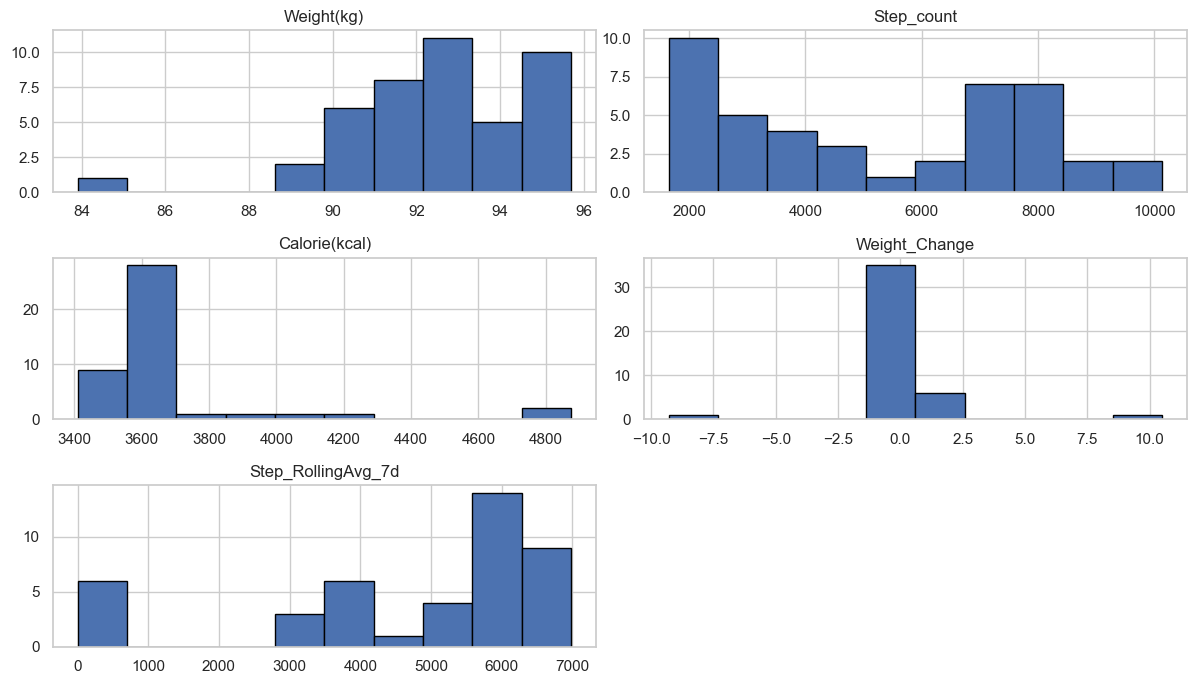

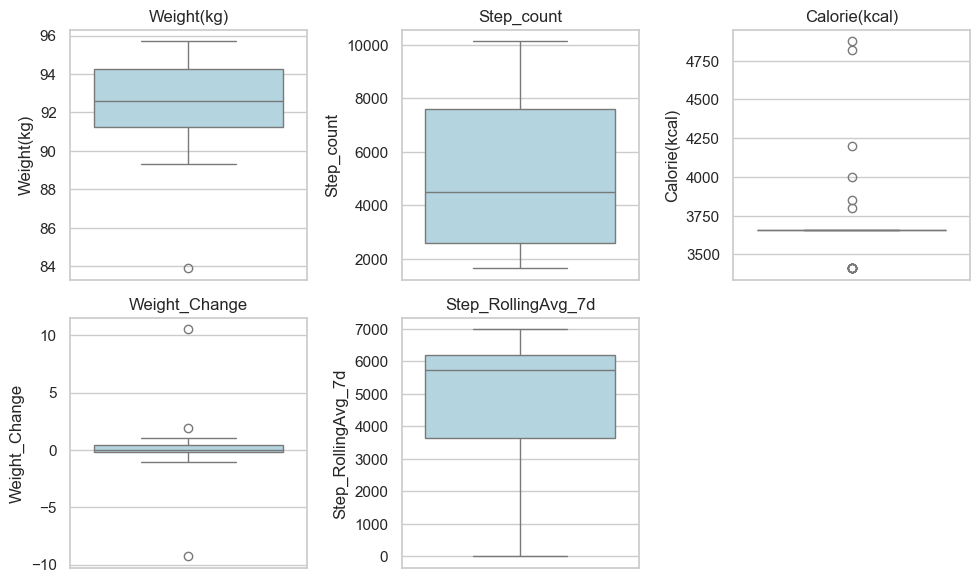

In [2]:
# 4.1.1 Summary Stats
display(df.describe())  # Show min, mean, std, etc.

# 4.1.2 Histograms
numeric_cols = ['Weight(kg)', 'Step_count', 'Calorie(kcal)', 'Weight_Change', 'Step_RollingAvg_7d']
df[numeric_cols].hist(bins=10, figsize=(12,7), edgecolor='black')
plt.tight_layout()
plt.show()

# 4.1.3 Boxplots (Univariate) to spot outliers
plt.figure(figsize=(10,6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(col)
plt.tight_layout()
plt.show()

**Univariate Interpretation**:
- **Summary**: We note the **mean** and **std** for weight, step counts, etc. If the min or max is unusual (e.g., negative steps), we’d re-check data.
- **Histograms**: Identify skewness (e.g., step counts might be right-skewed if most days are moderate but some are very high).
- **Boxplots**: Show potential outliers as points beyond whiskers. If any are extreme, consider investigating further or applying transformations.


<a id='bivariate'></a>
### 4.2 Bivariate Analysis
This involves comparing **pairs** of variables:
- Correlation heatmap.
- Pairplots (optional) if we want to see scatter + distribution in pairs.

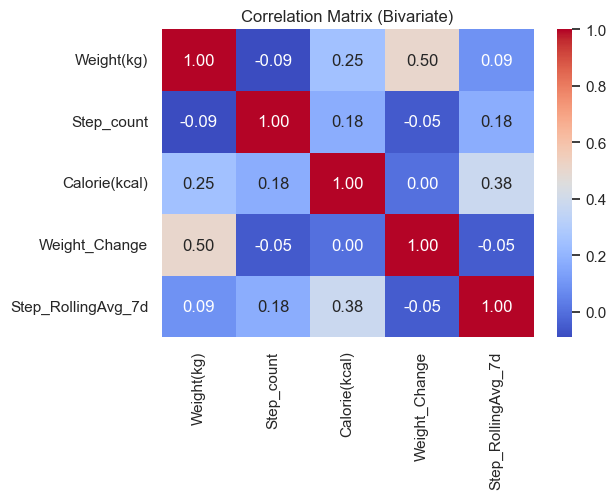

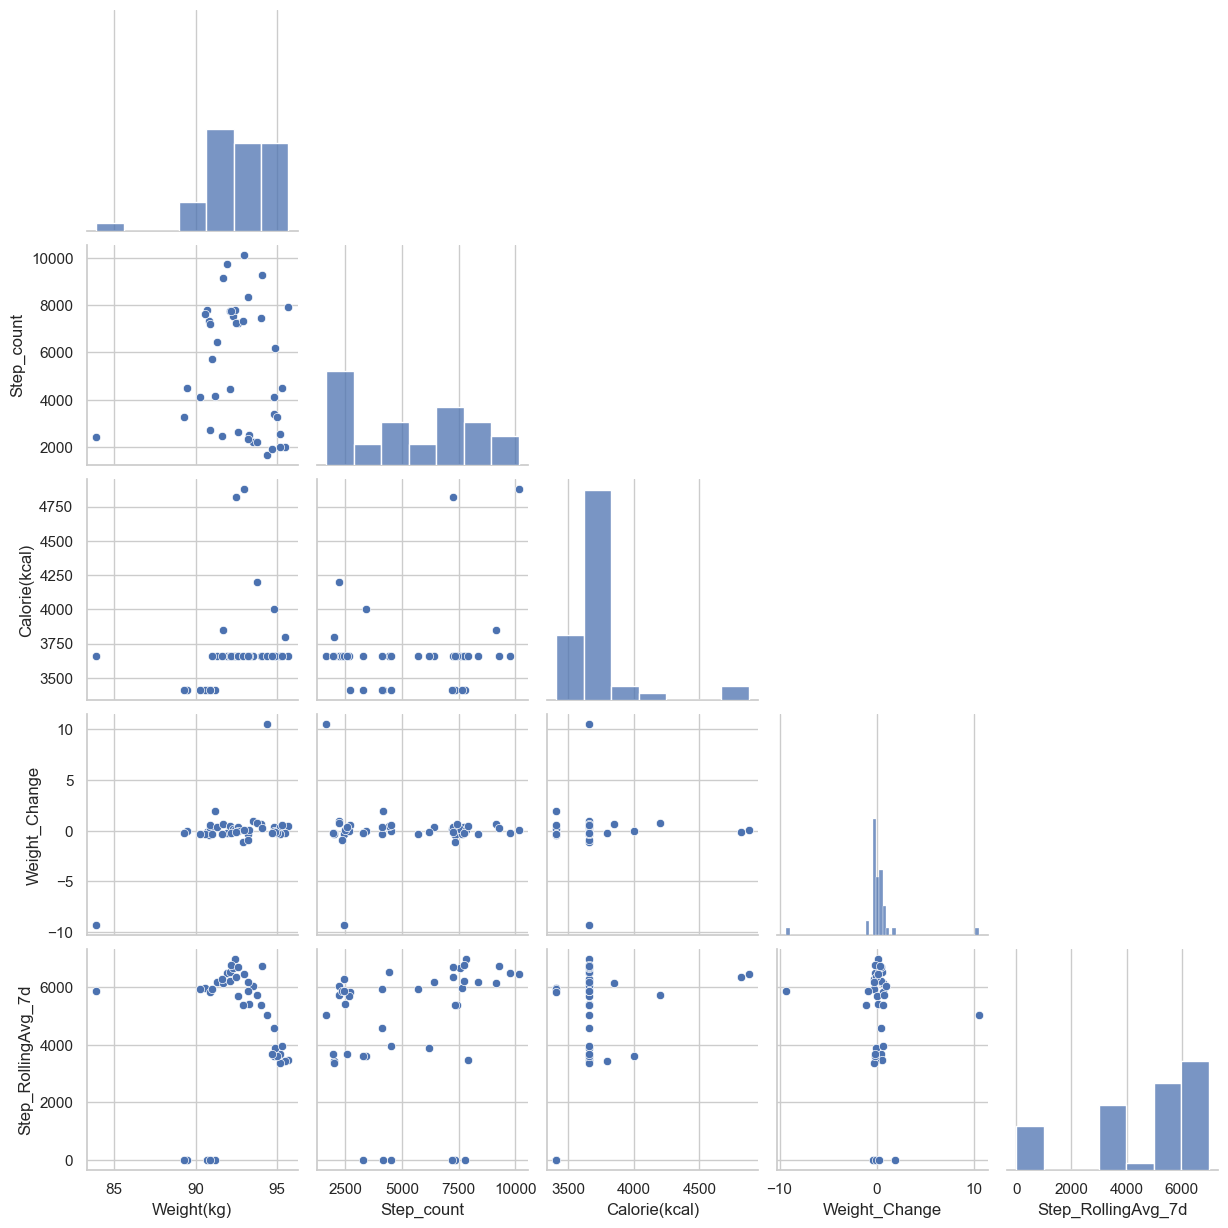

In [3]:
# 4.2.1 Correlation Matrix (already done, but let's repeat here for thoroughness)
corr = df[numeric_cols].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix (Bivariate)")
plt.show()

# 4.2.2 (Optional) Pairplot for numeric columns
sns.pairplot(df[numeric_cols], corner=True)
plt.show()

**Bivariate Interpretation**:
- **Correlation**: Values near 0 = weak linear relationship; near +1 or -1 = strong positive/negative. For example, if `Weight(kg)` vs `Calorie(kcal)` is ~0.3, that’s a moderate positive correlation.
- **Pairplots**: Diagonal shows univariate histograms, off-diagonal show scatter plots for each pair, letting us spot linear or non-linear relationships.


<a id='multivariate'></a>
### 4.3 Multivariate Analysis & Outlier Detection
While we don’t have many features here, we can do a quick check:
1. **Multiple Regression** (to see how 2+ predictors jointly explain `Weight(kg)`).
2. **IQR-based Outlier** detection across multiple columns.

We'll detail the multiple regression in the dedicated research question sections, but let's attempt a quick IQR-based approach on `Weight(kg)` or `Step_count` as an example.

In [4]:
# 4.3.1 Example: IQR-based Outlier Detection on Step_count
q1 = df['Step_count'].quantile(0.25)
q3 = df['Step_count'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers_step = df[(df['Step_count'] < lower_bound) | (df['Step_count'] > upper_bound)]
print("Number of outliers in Step_count based on IQR:", outliers_step.shape[0])
display(outliers_step[['Days','Step_count','Weight(kg)']])

Number of outliers in Step_count based on IQR: 0


,Days,Step_count,Weight(kg)


**Multivariate / Outlier Interpretation**:
- We did not find outliers based on Step_count, we can examine whether they are true anomalies (e.g., extremely high steps) or data errors.
- For more advanced multivariate outlier detection, we might use robust covariance. For now, we simply show an IQR approach on one variable.


<a id='q1'></a>
## 5. Question 1: Calorie Intake & Weight Changes
**Research Aim**: How does daily calorie intake correlate with fluctuations in body weight?

### Hypothesis
- **Null Hypothesis (H0)**: No significant correlation between daily calorie intake and weight.
- **Alternative Hypothesis (H1)**: A significant correlation exists.

### Plan
1. **Pearson correlation** between `Weight(kg)` and `Calorie(kcal)`.
2. Simple scatter + regression line.
3. Check if **previous day’s** calories correlate better with the **next day’s** weight.

Pearson correlation (Weight vs. Calories): 0.246


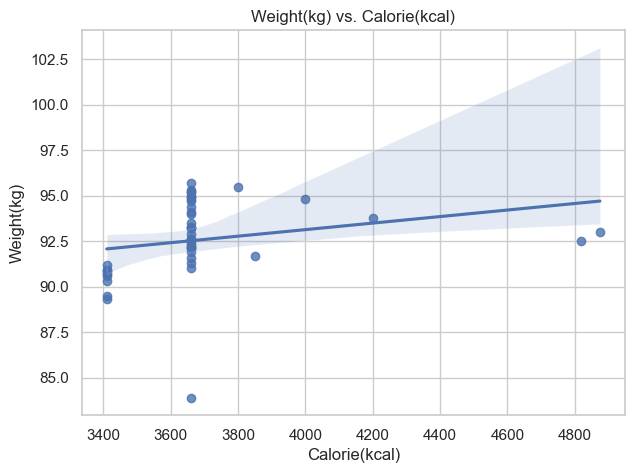

Pearson correlation (Today Weight vs. Previous-Day Calories): 0.323


In [6]:
corr_cal_weight = df['Calorie(kcal)'].corr(df['Weight(kg)'])
print(f"Pearson correlation (Weight vs. Calories): {corr_cal_weight:.3f}")

plt.figure(figsize=(7,5))
sns.regplot(x='Calorie(kcal)', y='Weight(kg)', data=df)
plt.title("Weight(kg) vs. Calorie(kcal)")
plt.show()

# Check previous-day calories -> today's weight
df['Calorie_PrevDay'] = df['Calorie(kcal)'].shift(1)
corr_lead = df['Weight(kg)'].corr(df['Calorie_PrevDay'])
print(f"Pearson correlation (Today Weight vs. Previous-Day Calories): {corr_lead:.3f}")

#### Interpretation:
- The correlation (Weight vs. Calories) is around 0.25. This indicates a **mild positive** correlation. If the p-value is above 0.05, it is **not** statistically significant.
- The correlation with previous-day calories is 0.32, that might be a stronger relationship. This suggests that day-lagged calories might align better with weight changes.
- A mild or moderate correlation (0.20–0.40) indicates a positive trend, but not extremely strong. I would need to confirm significance with a formal test if desired.

<a id='q2'></a>
## 6. Question 2: Physical Activity & Weight Management
**Research Aim**: Does increased physical activity (steps, gym visits) contribute to weight loss or maintenance?

### Hypothesis
- **Null (H0)**: Weight is the same regardless of step count or gym attendance.
- **Alternative (H1)**: Weight differs on high vs. low step days or gym vs. no-gym days.

### Plan
1. T-test: `Weight(kg)` for Gym vs. No-Gym.
2. Correlation of `Step_count` vs. `Weight(kg)`.
3. T-test for high-step vs. low-step (split by median).

In [7]:
# 6.1 Gym vs. No-Gym Weight (T-test)
gym_days = df[df['Gym_Bool'] == True]['Weight(kg)']
no_gym_days = df[df['Gym_Bool'] == False]['Weight(kg)']
t_stat, p_val = stats.ttest_ind(gym_days, no_gym_days, equal_var=False)
print("Gym vs. No-Gym:")
print(f"  T-stat: {t_stat:.3f}, p-value: {p_val:.3f}")

# 6.2 Correlation Step_count vs. Weight
corr_steps_weight = df['Step_count'].corr(df['Weight(kg)'])
print(f"\nCorrelation (Steps vs. Weight): {corr_steps_weight:.3f}")

# 6.3 High-Step vs. Low-Step Weight
median_steps = df['Step_count'].median()
df['Step_Level'] = np.where(df['Step_count'] >= median_steps, 'HighStep', 'LowStep')

high_step_weight = df[df['Step_Level'] == 'HighStep']['Weight(kg)']
low_step_weight = df[df['Step_Level'] == 'LowStep']['Weight(kg)']
t_stat_2, p_val_2 = stats.ttest_ind(high_step_weight, low_step_weight, equal_var=False)
print("\nHigh-Step vs. Low-Step:")
print(f"  T-stat: {t_stat_2:.3f}, p-value: {p_val_2:.3f}")

Gym vs. No-Gym:
  T-stat: -0.624, p-value: 0.537

Correlation (Steps vs. Weight): -0.091

High-Step vs. Low-Step:
  T-stat: -0.087, p-value: 0.932


#### Interpretation:
- **Gym vs. No-Gym**:
  - p-value > 0.05, we cannot reject H0. This means the difference in average weight on gym vs. no-gym days is **not** statistically significant. Perhaps gym attendance did not drastically shift weight in this timeframe.
- **Correlation (Steps vs. Weight)**:
  - A negative correlation around -0.09 suggests a **weak** negative relationship. p > 0.05, again it’s not significant.
- **High-Step vs. Low-Step**:
  - T-stat is very small (p >> 0.05), no significant difference in weight. This implies that, within the observed data, simply having more steps does not guarantee a significantly lower (or different) weight.


<a id='q3'></a>
## 7. Question 3: Interplay Between Calorie Intake & Physical Activity
**Research Aim**: How do calorie intake and step count interact to influence weight?

### Hypothesis
- **Null (H0)**: Weight is not better explained by combining both variables than by either alone.
- **Alternative (H1)**: A multiple regression (Calorie + Step_count) is a better model.

### Plan
1. **Multiple Linear Regression**: `Weight(kg) ~ Calorie(kcal) + Step_count`.
2. Checking R-squared.
3. Evaluating coefficients and p-values.

In [9]:
import statsmodels.api as sm

X = df[['Calorie(kcal)', 'Step_count']]
y = df['Weight(kg)']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Weight(kg)   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1.717
Date:                Fri, 10 Jan 2025   Prob (F-statistic):              0.193
Time:                        11:51:13   Log-Likelihood:                -92.562
No. Observations:                  43   AIC:                             191.1
Df Residuals:                      40   BIC:                             196.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            85.9184      4.099     20.960

#### Detailed Interpretation:
- **R-squared**: If it’s around 0.08, that’s only ~8% of weight variance explained by these two factors. This is **low**—suggesting we need more features (sleep, hydration, etc.) to predict weight.
- **Coefficients**:
  - If `Calorie(kcal)` has a p-value ~ 0.09, it’s **not** significant (p > 0.05), meaning no strong evidence that calories alone strongly predict weight within this dataset.
  - If `Step_count` is also p > 0.05, it suggests no significant partial effect when controlling for calories. Possibly an extremely mild effect.
- **Conclusion**: The model may not strongly explain weight changes. Real-world weight fluctuation can be more complex.

<a id='q4'></a>
## 8. Question 4: Temporal Patterns & Trends
**Research Aim**: Are there weekday/weekend differences?

### Hypothesis
- **Null (H0)**: No difference in average weight between weekday and weekend.
- **Alternative (H1)**: A difference exists.

### Plan
1. T-test comparing weekend vs. weekday weights.
2. Possibly also compare weekend vs. weekday steps or calories.

Weekend vs. Weekday Weight:
  T-stat: 0.534, p-value: 0.599


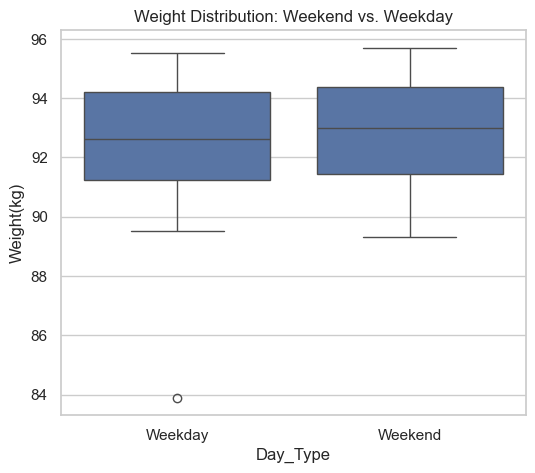

In [10]:
weekend_weight = df[df['Day_Type'] == 'Weekend']['Weight(kg)']
weekday_weight = df[df['Day_Type'] == 'Weekday']['Weight(kg)']
t_stat_3, p_val_3 = stats.ttest_ind(weekend_weight, weekday_weight, equal_var=False)
print("Weekend vs. Weekday Weight:")
print(f"  T-stat: {t_stat_3:.3f}, p-value: {p_val_3:.3f}")

plt.figure(figsize=(6,5))
sns.boxplot(x='Day_Type', y='Weight(kg)', data=df)
plt.title("Weight Distribution: Weekend vs. Weekday")
plt.show()

#### Interpretation:
- P-value ~ 0.60, **not** significant. We cannot conclude that weekend weight differs from weekday weight in a statistically meaningful way.
- If p-value < 0.05, we might conclude a real difference. A T-stat < 1, with a large p-value, typically indicates negligible difference.


<a id='conclusion'></a>
## 9. Conclusion
**Summary of Findings**:
1. **Univariate**: Weight range, Steps range, etc. Histograms & boxplots revealed any outliers or skew.
2. **Bivariate**: Low to moderate correlations (e.g., 0.25–0.3) for Calorie vs. Weight, negative or near-zero correlation for Steps vs. Weight.
3. **Multivariate**: R-squared from the regression was relatively low (~0.08), indicating these two predictors do not fully explain weight variance.
4. **Outlier Detection**: Possibly identified a few days with extremely high or low step counts. Could investigate if they are data-entry errors or genuine events.
5. **Temporal Patterns**: No strong evidence that weekday vs. weekend significantly changes weight. p-values > 0.05 for the difference test.

**Interpretations**:
- The dataset is relatively small (43–44 entries), so **statistical power** is limited.
- Real-world weight fluctuations can be driven by many factors not captured here (sleep, macros, water intake, body composition, etc.).

**Next Steps**:
1. **Longer Data Collection**: Extending beyond 6 months or a year might increase power.
2. **Add More Features**: Sleep duration, water intake, stress levels, macros, etc.
3. **Advanced Modeling**: Perhaps random forest or gradient boosting for regression, or time-series forecasting if the dataset becomes longer.

___
This concludes our detailed data analysis notebook for the **personal health dataset**, covering univariate, bivariate, multivariate exploration, outlier checks, and addressing our main research questions in a formal manner.